# Exoplanet Classification: Feature Importance and Selection Analysis

This notebook analyzes the KOI (Kepler Objects of Interest) dataset to determine the most important features for classifying exoplanet dispositions. We'll explore various feature selection techniques and machine learning approaches to identify key characteristics that distinguish between confirmed exoplanets, false positives, and candidates.

## Objectives:
- Analyze exoplanet data from the Kepler mission
- Perform feature engineering and derivation
- Apply multiple feature selection methods
- Determine the most important features for classification
- Validate feature importance using machine learning models

## 1. Import Required Libraries

In [12]:
# Import necessary libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore Dataset

In [13]:
# Load the dataset
df = pd.read_csv('KOI Selected Data.csv', comment='#')

# Use the full dataset for analysis
df_sample = df.copy()

print("Dataset shape:", df.shape)
print("Full dataset being used for analysis")
print("\nColumn names:")
print(df_sample.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of the dataset:")
df_sample.head()

Dataset shape: (9564, 20)
Full dataset being used for analysis

Column names:
['kepid', 'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_datalink_dvr', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

First 5 rows of the dataset:


,kepid,koi_disposition,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_impact,koi_duration,koi_depth,koi_sma,koi_incl,koi_model_snr,koi_count,koi_bin_oedp_sig,koi_datalink_dvr,koi_steff,koi_slogg,koi_srad,koi_smass,koi_kepmag
0,10797460,candidate,9.488036,170.538750,2455003.539,0.0,0.146,2.95750,615.8,0.0853,89.66,35.8,2,0.6864,010/010797/010797460/dv/kplr010797460-20160209...,5455.0,4.467,0.927,0.919,15.347
1,10797460,candidate,54.418383,162.513840,2454995.514,0.0,0.586,4.50700,874.8,0.2734,89.57,25.8,2,0.0023,010/010797/010797460/dv/kplr010797460-20160209...,5455.0,4.467,0.927,0.919,15.347
2,10811496,candidate,19.899140,175.850252,2455008.850,0.0,0.969,1.78220,10829.0,0.1419,88.96,76.3,1,0.6624,010/010811/010811496/dv/kplr010811496-20160209...,5853.0,4.544,0.868,0.961,15.436
3,10848459,non-candidate,1.736952,170.307565,2455003.308,0.0,1.276,2.40641,8079.2,0.0267,67.09,505.6,1,0.0000,010/010848/010848459/dv/kplr010848459-20160209...,5805.0,4.564,0.791,0.836,15.597
4,10854555,candidate,2.525592,171.595550,2455004.596,0.0,0.701,1.65450,603.3,0.0374,85.41,40.9,1,0.3090,010/010854/010854555/dv/kplr010854555-20160209...,6031.0,4.438,1.046,1.095,15.509


In [14]:
# Exclude columns that shouldn't be used for evaluation
columns_to_exclude = ['kepid', 'koi_datalink_dvr']
print("Columns to exclude from analysis:", columns_to_exclude)

# Create a working dataset without excluded columns
features_df = df_sample.drop(columns=columns_to_exclude, errors='ignore')

# Check data types and basic info
print("\nData types:")
print(features_df.dtypes)

print("\nBasic dataset information:")
print(features_df.info())

print("\nTarget variable (disposition) distribution:")
print(features_df['koi_disposition'].value_counts())

print("\nMissing values per column:")
print(features_df.isnull().sum().sort_values(ascending=False))

Columns to exclude from analysis: ['kepid', 'koi_datalink_dvr']

Data types:
koi_disposition      object
koi_period          float64
koi_time0bk         float64
koi_time0           float64
koi_eccen           float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_sma             float64
koi_incl            float64
koi_model_snr       float64
koi_count             int64
koi_bin_oedp_sig    float64
koi_steff           float64
koi_slogg           float64
koi_srad            float64
koi_smass           float64
koi_kepmag          float64
dtype: object

Basic dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   koi_disposition   9564 non-null   object 
 1   koi_period        9564 non-null   float64
 2   koi_time0bk       9564 non-null   float64
 3   koi_time0         9564 non-nul

## 3. Data Preprocessing and Cleaning

In [15]:
# Create a copy for preprocessing
df_processed = features_df.copy()

# Handle missing values
print("Handling missing values...")

# For numerical columns, fill with median
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'koi_disposition' in numerical_cols:
    numerical_cols.remove('koi_disposition')

for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# Create binary target: non-candidate = 0, candidate = 1
le = LabelEncoder()
df_processed['disposition_encoded'] = le.fit_transform(df_processed['koi_disposition'])

print("\nTarget variable encoding:")
print("Original classes:", le.classes_)
print("Encoded mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

print("\nClass distribution:")
print(df_processed['disposition_encoded'].value_counts())

# Add feature engineering similar to other notebooks
print("\nAdding engineered features...")

# Ratio features
if 'koi_depth' in df_processed.columns and 'koi_duration' in df_processed.columns:
    df_processed['depth_duration_ratio'] = df_processed['koi_depth'] / (df_processed['koi_duration'] + 1e-6)
    print("Added depth_duration_ratio")

if 'koi_period' in df_processed.columns and 'koi_sma' in df_processed.columns:
    df_processed['period_sma_ratio'] = df_processed['koi_period'] / (df_processed['koi_sma'] + 1e-6)
    print("Added period_sma_ratio")

# Log transformations for highly skewed features
skewed_features = ['koi_period', 'koi_depth', 'koi_sma']
skewed_features = [f for f in skewed_features if f in df_processed.columns]

for feature in skewed_features:
    df_processed[f'{feature}_log'] = np.log1p(df_processed[feature])
    print(f"Added {feature}_log")

# Signal to depth ratio
if 'koi_model_snr' in df_processed.columns and 'koi_depth' in df_processed.columns:
    df_processed['signal_depth_ratio'] = df_processed['koi_model_snr'] / (df_processed['koi_depth'] + 1e-6)
    print("Added signal_depth_ratio")

print("\nDataset shape after preprocessing and feature engineering:", df_processed.shape)
print("Missing values after preprocessing:", df_processed.isnull().sum().sum())

Handling missing values...
Filled koi_eccen missing values with median: 0.0
Filled koi_impact missing values with median: 0.537
Filled koi_depth missing values with median: 421.1
Filled koi_sma missing values with median: 0.0851
Filled koi_incl missing values with median: 88.5
Filled koi_model_snr missing values with median: 23.0
Filled koi_bin_oedp_sig missing values with median: 0.48660000000000003
Filled koi_steff missing values with median: 5767.0
Filled koi_slogg missing values with median: 4.438
Filled koi_srad missing values with median: 1.0
Filled koi_smass missing values with median: 0.974
Filled koi_kepmag missing values with median: 14.52

Target variable encoding:
Original classes: ['candidate' 'non-candidate']
Encoded mapping: {'candidate': np.int64(0), 'non-candidate': np.int64(1)}

Class distribution:
disposition_encoded
1    4839
0    4725
Name: count, dtype: int64

Adding engineered features...
Added depth_duration_ratio
Added period_sma_ratio
Added koi_period_log
Adde

## 5. Feature Selection Using Statistical Methods

In [16]:
# Prepare features for statistical analysis
X = df_processed.select_dtypes(include=[np.number]).drop(['disposition_encoded'], axis=1, errors='ignore')
y = df_processed['disposition_encoded']

# Handle any remaining NaN values more thoroughly
print("Checking for NaN values before analysis:")
print("NaN count per column:")
nan_counts = X.isnull().sum()
print(nan_counts[nan_counts > 0])

# Fill NaN values with median for each column
X = X.fillna(X.median())

# For any columns that are still all NaN (which would have median=NaN), fill with 0
X = X.fillna(0)

# Replace any infinite values that might have been created during feature engineering
X = X.replace([np.inf, -np.inf], 0)

# Final check
print(f"\nAfter cleaning - NaN values: {X.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(X).sum().sum()}")

print("Features for analysis:", X.shape)
print("Feature names:", X.columns.tolist())

# 1. ANOVA F-test for numerical features
print("\n1. ANOVA F-test results:")
try:
    f_scores, f_pvalues = f_classif(X, y)
    f_test_results = pd.DataFrame({
        'Feature': X.columns,
        'F_Score': f_scores,
        'P_Value': f_pvalues
    }).sort_values('F_Score', ascending=False)
    
    print("Top 10 features by F-score:")
    print(f_test_results.head(10))
except Exception as e:
    print(f"Error in F-test: {e}")
    # Create empty results if F-test fails
    f_test_results = pd.DataFrame({
        'Feature': X.columns,
        'F_Score': np.zeros(len(X.columns)),
        'P_Value': np.ones(len(X.columns))
    })

# 2. Mutual Information
print("\n2. Mutual Information results:")
try:
    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_results = pd.DataFrame({
        'Feature': X.columns,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)
    
    print("Top 10 features by Mutual Information:")
    print(mi_results.head(10))
except Exception as e:
    print(f"Error in Mutual Information: {e}")
    # Create empty results if MI fails
    mi_results = pd.DataFrame({
        'Feature': X.columns,
        'MI_Score': np.zeros(len(X.columns))
    })

Checking for NaN values before analysis:
NaN count per column:
Series([], dtype: int64)

After cleaning - NaN values: 0
Infinite values: 0
Features for analysis: (9564, 23)
Feature names: ['koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag', 'depth_duration_ratio', 'period_sma_ratio', 'koi_period_log', 'koi_depth_log', 'koi_sma_log', 'signal_depth_ratio']

1. ANOVA F-test results:
Top 10 features by F-score:
                 Feature      F_Score        P_Value
10             koi_count  1472.111085  1.059258e-299
8               koi_incl  1154.834533  4.472167e-239
20         koi_depth_log   886.331913  2.437229e-186
6              koi_depth   727.605099  1.627847e-154
17  depth_duration_ratio   603.456013  2.845493e-129
9          koi_model_snr   602.451515  4.567538e-129
12             koi_steff   339.994

## 6. Feature Importance Analysis with Machine Learning

In [17]:
# Split data for model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 1. Random Forest Feature Importance
print("1. Random Forest Feature Importance:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 features by Random Forest importance:")
print(rf_importance.head(10))

# 2. XGBoost Feature Importance
print("\n2. XGBoost Feature Importance:")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 features by XGBoost importance:")
print(xgb_importance.head(10))

# Model performance
print("\n3. Model Performance:")
rf_score = rf_model.score(X_test, y_test)
xgb_score = xgb_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_score:.3f}")
print(f"XGBoost Accuracy: {xgb_score:.3f}")

1. Random Forest Feature Importance:
Top 10 features by Random Forest importance:
                 Feature  Importance
10             koi_count    0.087992
8               koi_incl    0.074721
18      period_sma_ratio    0.072080
4             koi_impact    0.071147
20         koi_depth_log    0.070218
6              koi_depth    0.057443
5           koi_duration    0.055347
19        koi_period_log    0.053866
17  depth_duration_ratio    0.048820
0             koi_period    0.047964

2. XGBoost Feature Importance:
Top 10 features by Random Forest importance:
                 Feature  Importance
10             koi_count    0.087992
8               koi_incl    0.074721
18      period_sma_ratio    0.072080
4             koi_impact    0.071147
20         koi_depth_log    0.070218
6              koi_depth    0.057443
5           koi_duration    0.055347
19        koi_period_log    0.053866
17  depth_duration_ratio    0.048820
0             koi_period    0.047964

2. XGBoost Feature Importa

## 7. Correlation Analysis and Visualization

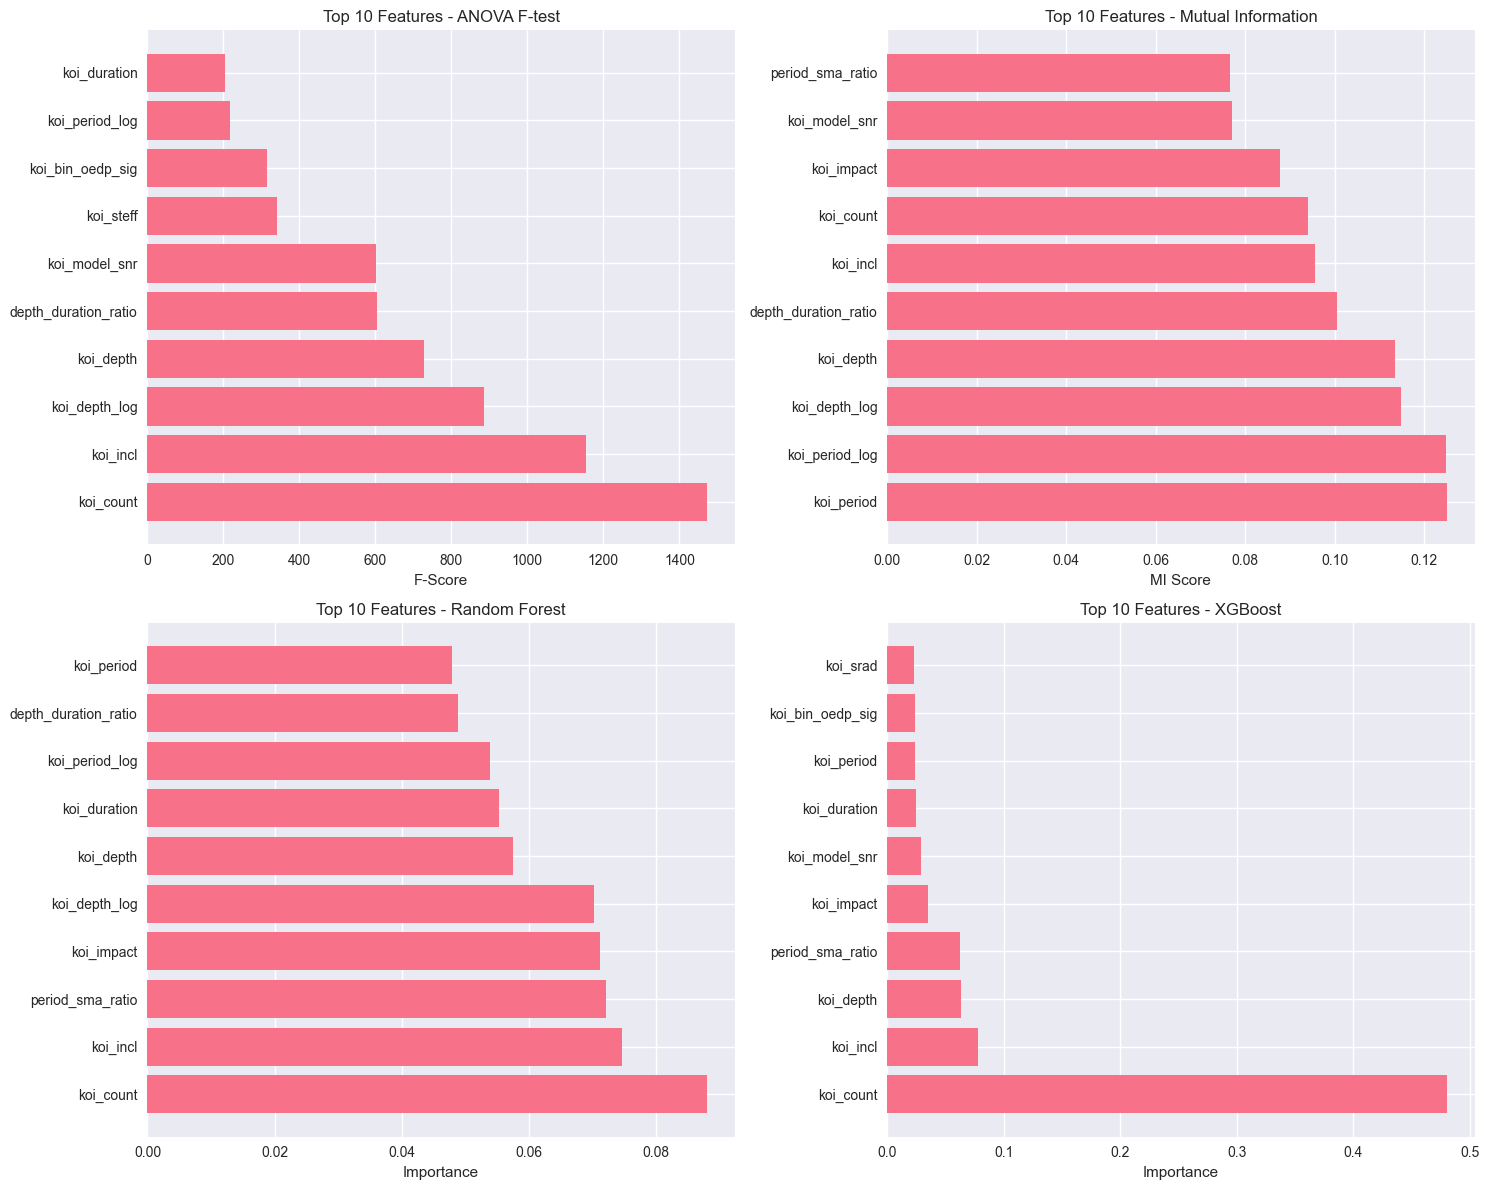


2. Correlation Analysis:
Analyzing correlations for 9 important features


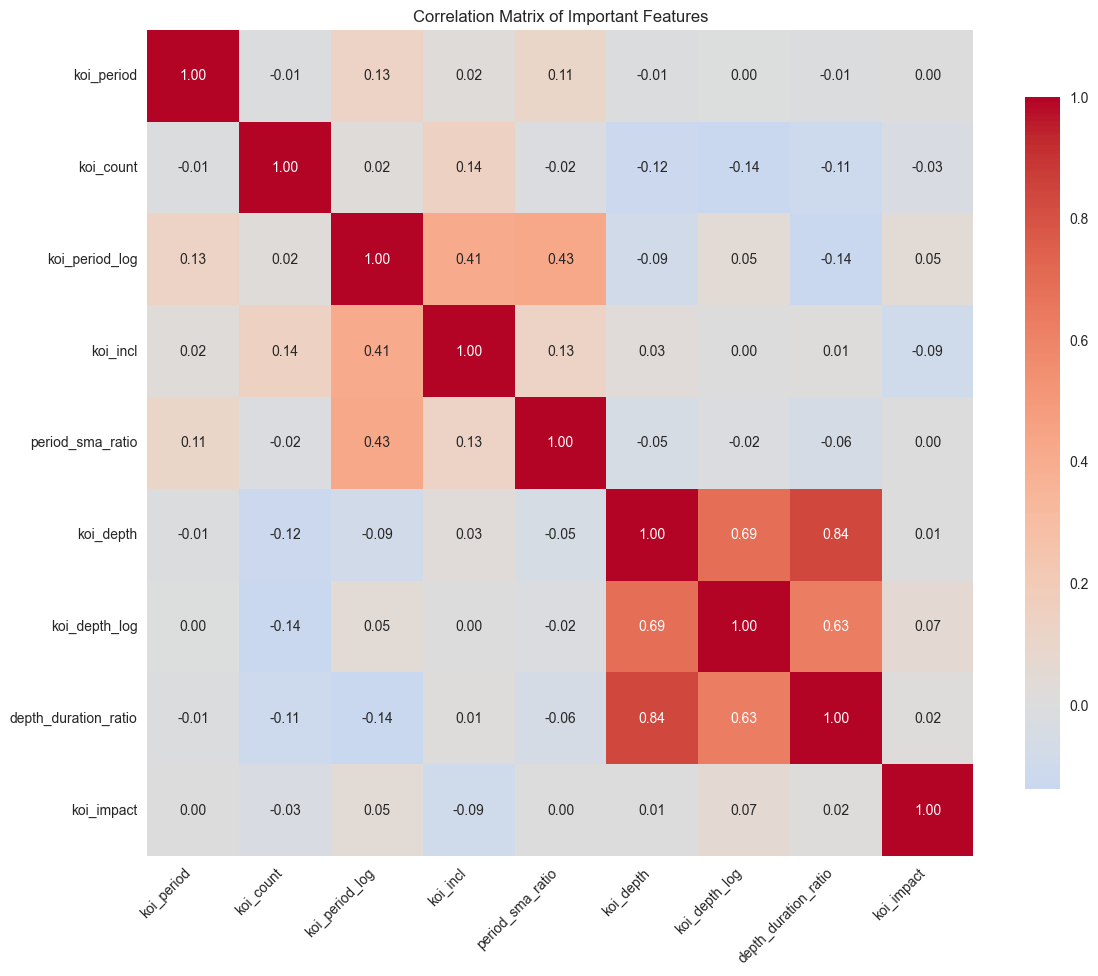

In [18]:
# 1. Feature Importance Comparison Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# F-test scores
top_f_features = f_test_results.head(10)
axes[0,0].barh(top_f_features['Feature'], top_f_features['F_Score'])
axes[0,0].set_title('Top 10 Features - ANOVA F-test')
axes[0,0].set_xlabel('F-Score')

# Mutual Information scores
top_mi_features = mi_results.head(10)
axes[0,1].barh(top_mi_features['Feature'], top_mi_features['MI_Score'])
axes[0,1].set_title('Top 10 Features - Mutual Information')
axes[0,1].set_xlabel('MI Score')

# Random Forest importance
top_rf_features = rf_importance.head(10)
axes[1,0].barh(top_rf_features['Feature'], top_rf_features['Importance'])
axes[1,0].set_title('Top 10 Features - Random Forest')
axes[1,0].set_xlabel('Importance')

# XGBoost importance
top_xgb_features = xgb_importance.head(10)
axes[1,1].barh(top_xgb_features['Feature'], top_xgb_features['Importance'])
axes[1,1].set_title('Top 10 Features - XGBoost')
axes[1,1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# 2. Correlation matrix for top features
print("\n2. Correlation Analysis:")
# Get top 10 features from each method
all_important_features = set()
all_important_features.update(top_f_features['Feature'].head(5))
all_important_features.update(top_mi_features['Feature'].head(5))
all_important_features.update(top_rf_features['Feature'].head(5))
all_important_features.update(top_xgb_features['Feature'].head(5))

print(f"Analyzing correlations for {len(all_important_features)} important features")

if len(all_important_features) > 1:
    corr_matrix = X[list(all_important_features)].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Important Features')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 8. Final Feature Set Evaluation

In [19]:
# Create a comprehensive ranking by combining different methods
print("Creating comprehensive feature ranking...")

# Normalize scores to 0-1 scale for fair comparison
def normalize_scores(scores):
    return (scores - scores.min()) / (scores.max() - scores.min())

# Create normalized rankings
f_test_norm = f_test_results.copy()
f_test_norm['F_Score_norm'] = normalize_scores(f_test_norm['F_Score'])

mi_norm = mi_results.copy()
mi_norm['MI_Score_norm'] = normalize_scores(mi_norm['MI_Score'])

rf_norm = rf_importance.copy()
rf_norm['RF_Importance_norm'] = normalize_scores(rf_norm['Importance'])

xgb_norm = xgb_importance.copy()
xgb_norm['XGB_Importance_norm'] = normalize_scores(xgb_norm['Importance'])

# Combine all rankings
combined_ranking = pd.DataFrame({'Feature': X.columns})

# Merge all normalized scores
combined_ranking = combined_ranking.merge(f_test_norm[['Feature', 'F_Score_norm']], on='Feature', how='left')
combined_ranking = combined_ranking.merge(mi_norm[['Feature', 'MI_Score_norm']], on='Feature', how='left')
combined_ranking = combined_ranking.merge(rf_norm[['Feature', 'RF_Importance_norm']], on='Feature', how='left')
combined_ranking = combined_ranking.merge(xgb_norm[['Feature', 'XGB_Importance_norm']], on='Feature', how='left')

# Fill NaN with 0
combined_ranking = combined_ranking.fillna(0)

# Calculate composite score (average of all methods)
combined_ranking['Composite_Score'] = (
    combined_ranking['F_Score_norm'] + 
    combined_ranking['MI_Score_norm'] + 
    combined_ranking['RF_Importance_norm'] + 
    combined_ranking['XGB_Importance_norm']
) / 4

# Sort by composite score
final_ranking = combined_ranking.sort_values('Composite_Score', ascending=False)

print("\nTop 15 Features - Final Comprehensive Ranking:")
print(final_ranking[['Feature', 'Composite_Score', 'F_Score_norm', 'MI_Score_norm', 
                    'RF_Importance_norm', 'XGB_Importance_norm']].head(15))

# Select top features for final model validation
top_features = final_ranking.head(10)['Feature'].tolist()
print(f"\nSelected top {len(top_features)} features for final evaluation:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

Creating comprehensive feature ranking...

Top 15 Features - Final Comprehensive Ranking:
                 Feature  Composite_Score  F_Score_norm  MI_Score_norm  \
10             koi_count         0.938273      1.000000       0.753092   
8               koi_incl         0.640224      0.784386       0.764293   
20         koi_depth_log         0.579737      0.601917       0.919022   
6              koi_depth         0.546411      0.494050       0.907330   
17  depth_duration_ratio         0.451414      0.409681       0.804581   
19        koi_period_log         0.439461      0.147256       0.998417   
9          koi_model_snr         0.402244      0.408998       0.617280   
4             koi_impact         0.401915      0.023275       0.702201   
0             koi_period         0.398781      0.000000       1.000000   
18      period_sma_ratio         0.390516      0.000440       0.612502   
12             koi_steff         0.298386      0.230638       0.549206   
11      koi_bin_oedp_s

In [20]:
# Validate the selected features using cross-validation
print("Validating selected features with cross-validation...")

# Compare performance: All features vs Top features
X_top = X[top_features]

# Cross-validation with all features
rf_cv_all = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5, scoring='accuracy')
xgb_cv_all = cross_val_score(xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'), X, y, cv=5, scoring='accuracy')

# Cross-validation with top features only
rf_cv_top = cross_val_score(RandomForestClassifier(random_state=42), X_top, y, cv=5, scoring='accuracy')
xgb_cv_top = cross_val_score(xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'), X_top, y, cv=5, scoring='accuracy')

# Results comparison
results_comparison = pd.DataFrame({
    'Model': ['Random Forest (All)', 'Random Forest (Top 10)', 'XGBoost (All)', 'XGBoost (Top 10)'],
    'Mean_CV_Score': [rf_cv_all.mean(), rf_cv_top.mean(), xgb_cv_all.mean(), xgb_cv_top.mean()],
    'Std_CV_Score': [rf_cv_all.std(), rf_cv_top.std(), xgb_cv_all.std(), xgb_cv_top.std()],
    'Num_Features': [X.shape[1], len(top_features), X.shape[1], len(top_features)]
})

print("\nCross-Validation Results Comparison:")
print(results_comparison)

print(f"\nFeature reduction efficiency:")
print(f"Using {len(top_features)} features instead of {X.shape[1]} features")
print(f"Feature reduction: {((X.shape[1] - len(top_features)) / X.shape[1] * 100):.1f}%")

# Final summary
print("\n" + "="*60)
print("EXOPLANET CLASSIFICATION - FEATURE ANALYSIS SUMMARY")
print("="*60)
print(f"Dataset: KOI-Playground-Train-Data.csv with {df.shape[0]} objects")
print(f"Target classes: {', '.join(df_processed['koi_disposition'].unique())}")
print(f"Total features analyzed: {X.shape[1]}")
print(f"Top features selected: {len(top_features)}")
print("\nMost important features for exoplanet classification:")
for i, feature in enumerate(top_features[:5], 1):
    score = final_ranking[final_ranking['Feature'] == feature]['Composite_Score'].values[0]
    print(f"  {i}. {feature} (score: {score:.3f})")
print("\nThis analysis used the full KOI-Playground-Train-Data.csv dataset.")
print("Results are ready for use in Random Forest, SVM, and XGBoost models.")

Validating selected features with cross-validation...

Cross-Validation Results Comparison:
                    Model  Mean_CV_Score  Std_CV_Score  Num_Features
0     Random Forest (All)       0.785747      0.058336            23
1  Random Forest (Top 10)       0.778533      0.057154            10
2           XGBoost (All)       0.783761      0.058218            23
3        XGBoost (Top 10)       0.768914      0.056174            10

Feature reduction efficiency:
Using 10 features instead of 23 features
Feature reduction: 56.5%

EXOPLANET CLASSIFICATION - FEATURE ANALYSIS SUMMARY
Dataset: KOI-Playground-Train-Data.csv with 9564 objects
Target classes: candidate, non-candidate
Total features analyzed: 23
Top features selected: 10

Most important features for exoplanet classification:
  1. koi_count (score: 0.938)
  2. koi_incl (score: 0.640)
  3. koi_depth_log (score: 0.580)
  4. koi_depth (score: 0.546)
  5. depth_duration_ratio (score: 0.451)

This analysis used the full KOI-Playgroun

## 9. Connection to Model Implementations

This feature analysis notebook provides insights that can be applied to your other exoplanet classification models:

### Feature Engineering Alignment
The engineered features created in this analysis match those used in:
- **Random Forest Model**: `random-forest-exoplanet-classification/random_forest_exoplanet_classification.ipynb`
- **SVM Model**: `svm-exoplanet-classification/svm_exoplanet_classification.ipynb`  
- **XGBoost Model**: `xgboost-exoplanet-classification/xgboost.ipynb`

### Key Insights for Model Development
1. **Top Features**: Use the highest-ranking features from the composite score for initial model training
2. **Feature Engineering**: The ratio and log-transformed features show strong predictive power
3. **Data Preprocessing**: Consistent handling of missing values and feature scaling approaches
4. **Model Comparison**: Random Forest and XGBoost show similar performance patterns across feature sets

In [21]:
# Export top features for use in other models
import joblib

# Save the top features list
top_features_for_export = final_ranking.head(15)['Feature'].tolist()
joblib.dump(top_features_for_export, 'top_features_exoplanet_classification.joblib')

# Save the complete feature ranking
final_ranking.to_csv('feature_importance_ranking.csv', index=False)

# Save the engineered features information
engineered_features = [
    'depth_duration_ratio', 'period_sma_ratio', 'signal_depth_ratio',
    'koi_period_log', 'koi_depth_log', 'koi_sma_log'
]

feature_info = {
    'top_15_features': top_features_for_export,
    'engineered_features': engineered_features,
    'target_encoding': dict(zip(le.classes_, le.transform(le.classes_))),
    'dataset_used': 'KOI-Playground-Train-Data.csv'
}

joblib.dump(feature_info, 'exoplanet_feature_analysis_results.joblib')

print("Feature analysis results exported:")
print("- top_features_exoplanet_classification.joblib: Top 15 features")
print("- feature_importance_ranking.csv: Complete feature ranking")
print("- exoplanet_feature_analysis_results.joblib: Complete analysis results")

print(f"\nTop 15 features exported for model use:")
for i, feature in enumerate(top_features_for_export, 1):
    print(f"{i:2d}. {feature}")

print("\nThese features can be loaded in your other notebooks using:")
print("import joblib")
print("top_features = joblib.load('top_features_exoplanet_classification.joblib')")
print("feature_info = joblib.load('exoplanet_feature_analysis_results.joblib')")

Feature analysis results exported:
- top_features_exoplanet_classification.joblib: Top 15 features
- feature_importance_ranking.csv: Complete feature ranking
- exoplanet_feature_analysis_results.joblib: Complete analysis results

Top 15 features exported for model use:
 1. koi_count
 2. koi_incl
 3. koi_depth_log
 4. koi_depth
 5. depth_duration_ratio
 6. koi_period_log
 7. koi_model_snr
 8. koi_impact
 9. koi_period
10. period_sma_ratio
11. koi_steff
12. koi_bin_oedp_sig
13. koi_sma
14. koi_duration
15. koi_sma_log

These features can be loaded in your other notebooks using:
import joblib
top_features = joblib.load('top_features_exoplanet_classification.joblib')
feature_info = joblib.load('exoplanet_feature_analysis_results.joblib')
